In [3]:
import string
import numpy as np
import random
import torch

# read in data, remove punctuation and make all lower case
def read_corpus(filename):
    corpus = []
    translator = str.maketrans('', '', string.punctuation)
    with open(filename) as f:
        for s in f:
            clean_s = s.translate(translator).lower()
            clean_words = clean_s.split()
            corpus.append(clean_words)
    return corpus

#Make data dictionaries and indexing 
def make_dictionaries(corpus):
    # create one set of all unique words
    flat_corpus = [w for s in corpus for w in s]
    corpus_set = set(flat_corpus)
    w_to_i = {}
    i_to_w = {}
    w_freq = []
    num_words = len(corpus_set)
    for i, w in enumerate(corpus_set):
        w_to_i[w] = i
        i_to_w[i] = w
        freq = flat_corpus.count(w)   
        w_freq.append([i, freq])
    return w_to_i, i_to_w, np.array(w_freq), num_words

def make_word_windows(corpus, window_size):
    windows = []
    
    for sentence in corpus:
        for i, word in enumerate(sentence):
            curr_window = np.zeros(shape=[5])
            
            #Check if index allows large enough window sampling
            if (i - WINDOW_SIZE > 0) and (i+ WINDOW_SIZE < len(sentence)):
                word_index = w_to_i[word]
                curr_window[0] = word_index
                n=1
                for j in range(i-WINDOW_SIZE, i+WINDOW_SIZE):
                    context_index=w_to_i[sentence[j]]
                    curr_window[n:] = context_index
                    n+=1
                windows.append(torch.LongTensor(curr_window))
    return windows

In [4]:
WINDOW_SIZE = 2
EMBEDDING_DIM = 128
BATCH_SIZE = 64
NUM_EPOCHS = 1

In [5]:
#SOME DECISIONS TO MAKE HERE BEFORE RUNNING WITH LARGE CORPUS: 
### 1st: Word window
### 2nd: What to do when sentence is smaller than window size? Disregard? Fill with 0s? 
### If the above, fix vocab index for -UNK-
### For now only keeping windows if sentences are large enough


corpus = read_corpus('wa/test.en')
w_to_i, i_to_w, w_freq, num_words = make_dictionaries(corpus)
data = make_word_windows(corpus, WINDOW_SIZE)

In [6]:
# def gau_kl(pm, pv, qm, qv):
#     """
#     Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
#     Also computes KL divergence from a single Gaussian pm,pv to a set
#     of Gaussians qm,qv.
#     Diagonal covariances are assumed.  Divergence is expressed in nats.
#     """
#     if (len(qm.shape) == 2):
#         axis = 1
#     else:
#         axis = 0
#     # Determinants of diagonal covariances pv, qv
#     dpv = pv.prod()
#     dqv = qv.prod(axis)
    
#     print("pv, dpv", pv.shape, dpv.shape, qv.shape, dqv.shape)
    
#     # Inverse of diagonal covariance qv
#     iqv = 1./qv
#     # Difference between means pm, qm
#     diff = qm - pm
    
#     print("KL component 1: ",  torch.log(dqv) - torch.log(dpv) )
#     print("KL component 2: ",  (iqv * pv).sum(axis)  )
#     print("KL component 3: ",  (diff * iqv * diff).sum(axis) )
#     print("KL component 4: ",  len(pm) )
          
    
    
#     return (0.5 *
#             (torch.log(dqv) - torch.log(dpv)            # log |\Sigma_q| / |\Sigma_p|
#              + (iqv * pv).sum(axis)          # + tr(\Sigma_q^{-1} * \Sigma_p)
#              + (diff * iqv * diff).sum(axis) # + (\mu_q-\mu_p)^T\Sigma_q^{-1}(\mu_q-\mu_p)
#              - len(pm)))                     # - N

# def kl_div(mu_1, sigma_1, mu_2, sigma_2):
#     div = torch.log(sigma_2) - torch.log(sigma_1) + (sigma_1.pow(2) + (mu_1 - mu_2).pow(2)) / (2*sigma_2.pow(2)) - 0.5
#     return div.sum()


# def _kl_divergence(mu_1, sigma_1, mu_2, sigma_2):
#         """
#         Batch wise computation of KL divergence between spherical Gaussians.
#         """
#         batch_size = mu_1.shape[0]
#         embed_size = mu_1.shape[2]
#         window_size = mu_2.shape[1]

#         # Means inner product with respect to Sigma_2. In: [B x W x D], out: [B x W]
#         means_diff = mu_2 - mu_1
#         ips2 = torch.matmul(means_diff.view(batch_size, window_size, 1,  embed_size),
#                             means_diff.view(batch_size, window_size, embed_size, 1)).view(batch_size, window_size)

#         # Compute rest of the KL training instance wise, sum over all instances and immediately average for loss
#         return 0.5 * (embed_size*(torch.log(sigma_2/sigma_1 + 1e-8) - 1 + sigma_1/sigma_2) + ips2/sigma_2)

# def _sample(self, mu, sigma):
#     """Reparameterized sampling from a Gaussian density."""
#     return mu + sigma * self.standard_normal.sample_n(mu.shape[0])

In [10]:
def kl_div(mu_1, sigma_1, mu_2, sigma_2):
#     print("KL component 1:", torch.log(sigma_2 + 1e-8))
#     print("KL component 2", torch.log(sigma_1 + 1e-8))
#     print("KL component 3:", (sigma_1.pow(2) + (mu_1 - mu_2).pow(2)) / (2*sigma_2.pow(2)))
#     print("KL component 3.num:", (sigma_1.pow(2) + (mu_1 - mu_2).pow(2)))
#     print("KL component 3.denom:", (2*sigma_2.pow(2)))

    D = mu_1.shape[0]
    diff = mu_2 - mu_1
    
    
    
    
#     print("shapes", mu_1.shape, sigma_1.shape, mu_2.shape, sigma_2.shape)
#     print(torch.mul(diff,1.0/sigma_2 ))
#     print(torch.dot(torch.mul(diff,1.0/sigma_2 ), diff ) )
    
    
    div = torch.log(torch.prod(sigma_2)/torch.prod(sigma_1) + 1e-8) - D 
            + torch.dot(1.0/sigma_2, sigma_1)
            + torch.dot(torch.mul(diff,1.0/sigma_2 ), diff )
    
    print('div', div)
    return div*0.5

In [13]:
import torch.nn as nn
from torch.distributions import MultivariateNormal

class bayesian_skipgram(nn.Module):
    def __init__(self, num_words, emb_dim):
        super(bayesian_skipgram, self).__init__()

        self.num_words = num_words
        self.emb_dim = emb_dim

        
        self.R = nn.Embedding(num_words, emb_dim)
        self.mu_prior = nn.Embedding(num_words, emb_dim)
        self.sigma_prior  = nn.Embedding(num_words, emb_dim)
        
        self.M = nn.Linear(2*emb_dim, 2*emb_dim)
        self.affine_lambda_mu = nn.Linear(2*emb_dim, emb_dim)
        self.affine_lambda_sigma = nn.Linear(2*emb_dim, emb_dim)
        self.affine_theta = nn.Linear(emb_dim, num_words)
        
        self.sfp = torch.nn.functional.softplus
        

    def forward(self, word_idx, context_idx):
        
        #print("Data forward: ", word_idx, context_idx) - OK
        R_w = self.R(word_idx) 
        R_w = R_w.unsqueeze(1)  
        R_w = R_w.repeat(1, len(context_idx[1]), 1) 
        R_cj = self.R(context_idx)
        
        
        RcRw = torch.cat((R_w, R_cj), dim=2)
        
        #print("Embeddings R concat: ", RcRw.shape, RcRw)

        h = nn.ReLU()(self.M(RcRw)) 
        h = torch.sum(h, dim=1)  

        mu = self.affine_lambda_mu(h)
        sigma_ = self.affine_lambda_sigma(h) #log
        #print("sigma_: ", sigma_.shape, sigma_)
        sigma = self.sfp(sigma_)
        
        print("mu: ", mu.shape, mu)
        print("sigma: ", sigma.shape, sigma)

        # reparametrization trick
        eps = MultivariateNormal(torch.zeros(self.emb_dim), torch.eye(self.emb_dim)).sample()
        z = mu + sigma * eps     
        
        
        print("z: ", z.shape, z)
       
        #########################################
    
        affine_ck = self.affine_theta(z)
        
        print('affine_ck', affine_ck)
        
        f_i = nn.functional.softmax(affine_ck, dim=1)  
                    
        print("f_i", f_i)
        
        mu_prior = self.mu_prior(word_idx)
        sigma_prior = self.sfp(self.sigma_prior(word_idx))
            
        #print("log_f_i", torch.log(f_i))
        ###################################################
        
        likelihood_terms = torch.zeros(word_idx.shape[0])
        KL_div_terms = torch.zeros(word_idx.shape[0])
        loss_terms = torch.zeros(word_idx.shape[0])
        
        
        for i, contexts in enumerate(context_idx):
            
            #likelihood term
            likelihood = 0

            
            for idx in contexts:
                likelihood += torch.log(f_i[i, idx] +1e-8)
            likelihood_terms[i] = likelihood
            
            KL =  kl_div( mu[i], sigma[i], mu_prior[i] , sigma_prior[i])
            KL_div_terms[i] = KL
            
            
            #total loss term
            loss_terms[i] = (KL - likelihood)

            #print("Likelihood: ", likelihood, " KL:", KL, " Total:", KL - likelihood)
        
        print("Likelihood", likelihood_terms.shape, torch.mean(likelihood_terms), torch.min(likelihood_terms))
        print("KL", KL_div_terms.shape, torch.mean(KL_div_terms), torch.min(likelihood_terms))
        print("loss", loss_terms.shape, loss_terms)
          
        total_loss= torch.mean(loss_terms)   #+= (KL - likelihood)
        print("TOTAL loss", total_loss)
             
        return total_loss

mu:  torch.Size([64, 128]) tensor([[ 1.4101, -0.3634, -0.5814,  ..., -0.2060, -1.4785,  0.0970],
        [ 0.7293, -0.1988, -0.1312,  ..., -0.2234,  0.2429,  0.1190],
        [ 1.2531,  0.4656,  0.2886,  ...,  1.3023, -1.0846,  0.5115],
        ...,
        [ 0.3340,  0.3986, -0.2158,  ...,  1.3138, -1.1402,  0.1532],
        [ 1.8529,  0.1748, -0.0969,  ..., -0.4812,  0.3685,  0.3060],
        [ 0.7510,  0.5928,  0.2582,  ...,  0.8627, -0.4142, -0.5176]])
sigma:  torch.Size([64, 128]) tensor([[ 0.7192,  0.1470,  1.2978,  ...,  0.5261,  1.3440,  0.5625],
        [ 0.7886,  0.5293,  0.6340,  ...,  0.5575,  0.7633,  0.5666],
        [ 1.8228,  0.1947,  1.7109,  ...,  0.5299,  1.4976,  0.6294],
        ...,
        [ 1.2679,  0.4028,  0.6145,  ...,  0.4032,  0.9267,  1.0932],
        [ 0.3017,  0.3690,  0.7986,  ...,  0.7154,  1.0455,  0.8356],
        [ 1.4279,  0.1685,  1.4935,  ...,  0.4342,  1.6947,  0.7371]])
z:  torch.Size([64, 128]) tensor([[ 1.4910, -0.4311, -3.7736,  ..., -0.1909

sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [

mu:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan.,

f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div ten

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

mu:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan.,

f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div ten

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

mu:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan.,

f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div ten

sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

mu:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
sigma:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan.,

f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div ten

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

z:  torch.Size([64, 128]) tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., na

affine_ck tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
f_i tensor([[nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        ...,
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.],
        [nan., nan., nan.,  ..., nan., nan., nan.]])
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(nan.)
div tensor(

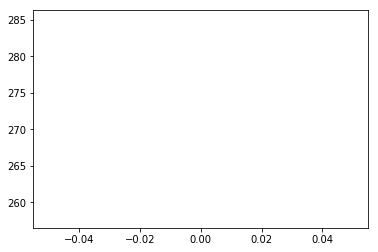

In [14]:
# TRAIN NETWORK
%matplotlib inline
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

dataloader = DataLoader(data, batch_size=64, shuffle=True)
use_cuda = torch.cuda.is_available()

BSG_model = bayesian_skipgram(num_words, EMBEDDING_DIM)
optimizer = torch.optim.SGD(BSG_model.parameters(), lr=0.01)


start_time = time.time()


if use_cuda:
    BSG_model.cuda()

BSG_model.train()
loss_progress = []
iter_time = time.time()

for epoch in range(NUM_EPOCHS):
    for i, data_batch in enumerate(dataloader, 0):
        main_word = data_batch[:,0]
        context_word = data_batch[:,1:]
        
        
        optimizer.zero_grad()
        
        if use_cuda:
            loss = BSG_model.forward(main_word.cuda(), context_word.cuda())
        else:
            loss = BSG_model.forward(main_word, context_word)
        
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            loss_progress.append(loss.item())  
        if i % 25000 == 0:
            print(loss_progress[-1])
            print("TIME: " , time.time()-iter_time)
            iter_time = time.time()


print("total time taken:", time.time()-start_time)
plt.plot(loss_progress)
plt.show()